# Causal Effect of Amazon Warehouses on Employment and Wage

#### Name: Scott Kim <br> Email: [scott.kim@stern.nyu.edu](scott.kim@stern.nyu.edu) 

** Summary and Background: ** <br> The aim of this project will be to estimate the causal effect of Amazon facilities on unemployment and wage. The inspiration for this project came from The Economist [article](https://www.economist.com/news/united-states/21735020-worlds-largest-online-retailer-underpaying-its-employees-what-amazon-does-wages) that we read in class during this semester. This article detailed how once Amazon opened up a warehousing facility in Lexington County, South Carolina, total employment in the warehousing and storage industry increased sharply while wage unexpectedly dropped. While the infographic paints an interesting tale, a lot of variables weren't mentioned and thus left me with many questions. Did the total employment increase because Amazon brought with it employers from other states? Or did it increase because employees from other industries, or even similar industries, joined Amazon's warehouse? If it were either of these reasons, the benefit of Amazon's job creation seems to be a surface level effect. Perhaps unrelated to these reasons though, the boost in employment could have simply been a result from a general rising trend in employment throughout the state. We can even go further and ask whether a county being urban or rural has an impact on the net level of employment and wage received from Amazon Fulfilment Centers.

While I currently don't have the resources to completely explore this issue, my research project hopes to explore these types of questions. It will first focus on identifying a similar effect for all of the counties that have been exposed to new Amazon warehouses. It is very possible that the type of trend we saw in Lexington County was specific only to Lexington County. Before I answer any of these more complicated questions mentioned before, this is one I plan to address first.

** Data: ** <br> The data that I will use in this project comes from four main sources:

1) ** [Bureau of Economic Analysis](https://www.bea.gov/API/bea_web_service_api_user_guide.htm): ** The data from the Bureau of Economic Analysis will be the foundation for this project. With it, I am able to access the total employment and compensation of workers across counties and years from 2001 to 2014 within the transportation and warehousing industry.

The two TableNames and their respective keys that I've used in this project are listed below.

* CA25N - Total Full-Time and Part-Time Employment by NAICS Industry
* CA6N - Compensation of Employees by NAICS Industry
* Key 800 - Private nonfarm employment: Transportation and warehousing (NAICS:48-49)

2) ** [MWPVL International](http://www.mwpvl.com/html/amazon_com.html): ** MWPVL International is a specialized supply chain, logistics, and distribution firm that has compiled a data set on Amazon's warehouses. This data set details the size in square feet, location, type, and the year opened of all the warehouses. With this data, I'm able to locate which counties were treated with Amazon warehouses in which year, and thus am able to identify the before and after effects of these facilities across all affected counties. However, the website is protected and will not allow me to copy the data. Because of this consideration, I have decided to use only the data on * The Amazon Fulfillment Center and Distribution Center Network in the United States * within this project.

3) ** [Bureau of Labor Statistics](https://www.bls.gov/data/): ** The data from the Bureau of Labor Statistics share similar attributes to the data from the Bureau of Economic Analysis. With it, I am able to access the total employment and compensation of workers across counties and years until as recently as 2016. However, due to the manual labour this method of data extraction requires, I will use this data set only to replicate the figure seen in The Economist article. 

The keys and specifications for the manipulation of these data sets are listed below.

* ENU45063105493 - Quarterly Census of Employment and Wages --> 493 NAICS 493 Warehousing and storage --> 45063 Lexington County, South Carolina --> Private --> All Employees --> All establishment sizes
* ENU45063405493 - Quarterly Census of Employment and Wages --> 493 NAICS 493 Warehousing and storage --> 45063 Lexington County, South Carolina --> Private --> Average Weekly Wage --> All establishment sizes

4) ** [United States Census Bureau](https://www.census.gov/geographies/reference-files/time-series/demo/metro-micro/delineation-files.html): ** The Census Bureau provides a list of all counties that are a metropolitan statistical area, or a micropolitan statistical area. Furthermore, they provide this data along with the FIPS county codes, which will make our lives easier later when merging our data. These classifications will be used later to see whether a county being urban has an impact on Amazon's choices to establish a fulfilment center, and the effects on employment and wage.

---

Using these data sets, I eventually intend on conducting a two-way fixed effects regression to address time and county specific trends, as well as utilizing Cox Proportional-Hazards and Tobit models to account for counties that have been treated with several Amazon Fulfilment Centers. While running such analyses, I will scale the data to account for issues like the differences in county populations, as well as inflation for wage figures. I also plan on running F-tests to check whether there are any significant differences between different types of counties (urban, semi-urban, or rural) and types of fulfilment centers.

Furthermore, I wish to find appropriate instrumental variables to include in my regressions to address potential endogeneity issues. A possible idea for such an instrumental variable is identifying counties in which Amazon Fulfilment Centers were planned but cancelled for some unrelated reasons. Another option is to use the time lag between when plans for an Amazon Fulfilment Center is an announced and the time of official opening.

---
** Import packages that are necessary for the project: **

In [1]:
import pandas as pd              # to create and manipulate DataFrames
import numpy as np               # to better handle numbers
import requests                  # to extract data from APIs
import matplotlib.pyplot as plt  # to plot visually appealing graphs
import matplotlib as mpl
import weightedcalcs as wc       # to better run statistical processes
import string                    # to clean punctuation
import math

---
### Bureau of Labor Statistics

I want to start this project by trying to mimic The Economist's figure in the aforementioned article. To perfectly replicate this, and to ensure that my process is right, I've used data from the Bureau of Labor Statistics.

** Read in Lexington County data: **

In [20]:
lexington_wage = pd.read_csv("https://raw.githubusercontent.com/scottjmkim/Data_Bootcamp_Final_Project/master/data/ENU45063405493.csv")
lexington_employment = pd.read_csv("https://raw.githubusercontent.com/scottjmkim/Data_Bootcamp_Final_Project/master/data/ENU45063105493.csv")

** Contextualize and clean the data: **

In [21]:
lexington_wage.rename(columns = {"Annual": "Weekly Wage"}, inplace = True)
lexington_employment.rename(columns = {"Annual": "Total Employment"}, inplace = True)

sc_lexington = pd.merge(lexington_wage, lexington_employment,on = "Year")

sc_lexington["Total Employment"] = sc_lexington["Total Employment"] / 1000
sc_lexington["Weekly Wage"] = sc_lexington["Weekly Wage"]

sc_lexington.set_index("Year", inplace = True)

sc_lexington

,Weekly Wage,Total Employment
Year,,
2004,686,0.118
2005,690,0.126
2006,601,0.207
2007,731,0.261
2008,738,0.240
2009,891,0.139
2010,849,0.147
2011,823,0.278
2012,697,1.062


** Plot the data as shown by The Economist: **

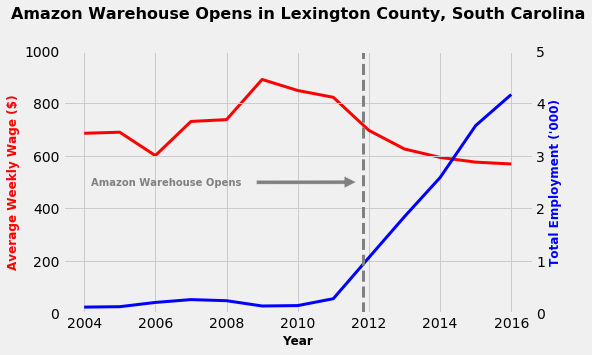

In [24]:
fig, ax1 = plt.subplots(figsize = (7.5, 4.5))

ax2 = ax1.twinx()

sc_lexington["Weekly Wage"].plot(ax = ax1, color = "r", linewidth = 3.0, label = "Average Weekly Wage")
sc_lexington["Total Employment"].plot(ax = ax2, color = "b", linewidth = 3.0, label = "Total Employment")

ax1.set_title("Amazon Warehouse Opens in Lexington County, South Carolina", fontsize = 16, fontweight = "bold")
ax1.title.set_position([.5, 1.1])

ax1.set_xlabel("Year", fontsize = 12, fontweight = "bold")
ax1.set_ylabel("Average Weekly Wage ($)", color = "r", fontsize = 12, fontweight = "bold")
ax2.set_ylabel("Total Employment ('000)", color = "b", fontsize = 12, fontweight = "bold")

ax1.set_ylim(0, 1000)
ax2.set_ylim(0, 5)

plt.axvline(x = 2011.83, color = "gray", linewidth = 3.0, linestyle = "--")

ax1.annotate("Amazon Warehouse Opens", 
             xy=(2012, 500), 
             xytext=(2004.2, 488), 
             fontsize = 10,
             fontweight = "bold", 
             color = "gray", 
             arrowprops = dict(facecolor = "gray", shrink = 0.10))

plt.style.use("fivethirtyeight")

# mpl.rcParams.update(mpl.rcParamsDefault)
# %matplotlib inline

plt.show()

Here we see that the figure is almost identical to the one we saw in The Economist article. We see the recurring trend of employment and wage increasing and decreasing respectively upon an Amazon warehouse appearing. 

Unfortunately, as mentioned before I do not currently have a wage of retrieving the data for all counties simultaneously from the BLS. Therefore, moving forward I will be using data from the Bureau of Economic Analysis. This data does not contain data that is as specific to the industry *493 NAICS 493 Warehousing and storage*. Instead, it contains data on the broader category *Transportation and warehousing (NAICS:48-49)*. However, as we will find out later on, this allows us to further ascertain the nature of the shift of employment in the figure above.

---
### Bureau of Economic Analysis

Fortunately, the Bureau of Economic Analysis allows for the easy aggregation of data on the county and industry level. Going forward in the project, the data from the BEA will be used instead of the BLS data as it allows for more efficient analyses with more data entries, resulting in a higher accuracy as well.

** Set up variables required to access the Bureau of Economic Analysis's API. Once that is done, look for the key for the warehousing industry: **

In [23]:
BEA_ID = "72DF5D45-977D-49AC-B6D8-9D485484C815"

my_key = "https://apps.bea.gov/api/data?&UserID=" + BEA_ID + "&"

data_set = "datasetname=RegionalIncome&"

method = "method=GetParameterValuesFiltered&"

dataset = "datasetname=RegionalIncome&"

linecode = "TargetParameter=LineCode&"

tablename = "TableName=CA25N&"

location = "GeoFips=COUNTY&"

form = "ResultFormat=json"

API_URL = my_key + method + dataset + linecode + tablename + form

r = requests.get(API_URL)

r.json()["BEAAPI"]["Results"]

{'ParamValue': [{'Desc': '[CA25N] Total employment', 'Key': '10'},
  {'Desc': '[CA25N] Private nonfarm employment: Forestry, fishing, and related activities (NAICS:113-115)',
   'Key': '100'},
  {'Desc': '[CA25N] Private nonfarm employment: Finance and insurance (NAICS:52)',
   'Key': '1000'},
  {'Desc': '[CA25N] Private nonfarm employment: Real estate and rental and leasing (NAICS:53)',
   'Key': '1100'},
  {'Desc': '[CA25N] Private nonfarm employment: Professional, scientific, and technical services (NAICS:54)',
   'Key': '1200'},
  {'Desc': '[CA25N] Private nonfarm employment: Management of companies and enterprises (NAICS:55)',
   'Key': '1300'},
  {'Desc': '[CA25N] Private nonfarm employment: Administrative and support and waste management and remediation services (NAICS:56)',
   'Key': '1400'},
  {'Desc': '[CA25N] Private nonfarm employment: Educational services (NAICS:61)',
   'Key': '1500'},
  {'Desc': '[CA25N] Private nonfarm employment: Health care and social assistance (NAIC

** Adjust the variables to now extract the data into a Pandas DataFrame: **

In [25]:
my_key = "https://apps.bea.gov/api/data?&UserID=" + BEA_ID + "&method=GetData&"

table_and_line_employment = "TableName=CA25N&LineCode=800&"

API_URL = my_key + data_set + table_and_line_employment + location + form

r_total_employment = requests.get(API_URL)

df_total_employment = pd.DataFrame(r_total_employment.json()["BEAAPI"]["Results"]["Data"])

df_total_employment.head()

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
0,Number of jobs,CA25N-800,"6,012,800",00000,United States,NaN,2013,0
1,Number of jobs,CA25N-800,"6,282,400",00000,United States,NaN,2014,0
2,Number of jobs,CA25N-800,"6,929,700",00000,United States,NaN,2015,0
3,Number of jobs,CA25N-800,"7,413,200",00000,United States,NaN,2016,0
4,Number of jobs,CA25N-800,"7,663,800",00000,United States,NaN,2017,0


** Make the list of years applicable for the scope of this project (2001 to 2014): **

In [26]:
years = range(2001, 2018)

years = list(years)

years = "".join(str(years))

years = years[1:-1]

** Include the list of years as a variable when retrieving data: **

In [27]:
year = "Year=" + years + "&"

API_URL = my_key + data_set + table_and_line_employment + year + location + form

r = requests.get(API_URL)

df_total_employment = pd.DataFrame(r.json()["BEAAPI"]["Results"]["Data"])

r_total_employment = requests.get(API_URL)

df_total_employment = pd.DataFrame(r_total_employment.json()["BEAAPI"]["Results"]["Data"])

df_total_employment.head()

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
0,Number of jobs,CA25N-800,"5,480,000",00000,United States,NaN,2001,0
1,Number of jobs,CA25N-800,"5,355,300",00000,United States,NaN,2002,0
2,Number of jobs,CA25N-800,"5,308,500",00000,United States,NaN,2003,0
3,Number of jobs,CA25N-800,"5,415,800",00000,United States,NaN,2004,0
4,Number of jobs,CA25N-800,"5,602,300",00000,United States,NaN,2005,0


** Clean the DataFrame by dropping and renaming some columns: **

In [28]:
df_total_employment.drop(['CL_UNIT', 'Code',"NoteRef", "UNIT_MULT"], axis=1, inplace = True)

df_total_employment.rename(columns = {"DataValue":"TotalEmployment", "TimePeriod": "Year"}, inplace = True)

df_total_employment.head()

,TotalEmployment,GeoFips,GeoName,Year
0,"5,480,000",00000,United States,2001
1,"5,355,300",00000,United States,2002
2,"5,308,500",00000,United States,2003
3,"5,415,800",00000,United States,2004
4,"5,602,300",00000,United States,2005


---
** Now do the same for personal income: **

In [29]:
table_and_line_income = "TableName=CA6N&LineCode=800&"

API_URL = my_key + data_set + table_and_line_income + year + location + form

r_income = requests.get(API_URL)

df_income = pd.DataFrame(r_income.json()["BEAAPI"]["Results"]["Data"])

df_income.drop(['CL_UNIT', 'Code',"NoteRef", "UNIT_MULT"], axis=1, inplace = True)

df_income.rename(columns = {"DataValue":"Income", "TimePeriod": "Year"}, inplace = True)

df_income.head()

,Income,GeoFips,GeoName,Year
0,"207,971,000",00000,United States,2001
1,"206,299,000",00000,United States,2002
2,"209,859,000",00000,United States,2003
3,"222,029,000",00000,United States,2004
4,"231,614,000",00000,United States,2005


Unfortunately, the BEA does not have data on the average income per worker for each industry. Since no data set exists, we must find the next best alternative. As we have the total amount of workers per county for each year, we can average it out using the two DataFrames later on.

Furthermore, the figures are listed in thousands of dollars. This is something we can remedy easily later on.

---
** Now merge both DataFrames into one: **

In [30]:
master = pd.merge(df_total_employment, df_income,
                 how = "inner",
                 on = ["GeoFips", "Year", "GeoName"],
                 indicator = True)

** Clean the DataFrame of any invalid strings and set variables as floats: **

In [31]:
exclude = set(string.punctuation)
def remove_punctuation(x):
    try:
        x = ''.join(ch for ch in x if ch not in exclude)
    except:
        pass
    return x

In [32]:
master["TotalEmployment"].replace(["(NA)", "(D)", "(L)"], np.nan, inplace = True)
master["TotalEmployment"] = master["TotalEmployment"].apply(remove_punctuation)
master["TotalEmployment"] = master["TotalEmployment"].astype(float)

master["Income"].replace(["(NA)", "(D)", "(L)"], np.nan, inplace = True)
master["Income"] = master["Income"].apply(remove_punctuation)
master["Income"] = master["Income"].astype(float)

# master["Year"] = pd.to_datetime(master["Year"], infer_datetime_format = True)
master["Year"] = master["Year"].astype(float)

** Make a new column finding the average income: **

In [33]:
master["AverageIncome"] = master["Income"] * 1000 / master["TotalEmployment"]

master.drop(["Income"], axis=1, inplace = True)
master.drop(["_merge"], axis = 1, inplace = True)

master.head()

,TotalEmployment,GeoFips,GeoName,Year,AverageIncome
0,5480000.0,00000,United States,2001.0,37950.912409
1,5480000.0,00000,United States,2001.0,37950.912409
2,5480000.0,00000,United States,2001.0,37950.912409
3,5480000.0,00000,United States,2001.0,37950.912409
4,5355300.0,00000,United States,2002.0,38522.398372


We can now drop the * Income * column as we have the average income data.

** Now Clean the data more and include new columns of CountyFips and Treated: **

In [34]:
master["CountyFips"] = master["GeoFips"].str[2:]
master["Amazon"] = 0
master["TreatedDate"] = 0

master = master[master["CountyFips"] != "000"]

master.head()

,TotalEmployment,GeoFips,GeoName,Year,AverageIncome,CountyFips,Amazon,TreatedDate
85,344.0,01001,"Autauga, AL",2001.0,23741.279070,001,0,0
86,325.0,01001,"Autauga, AL",2002.0,24556.923077,001,0,0
87,327.0,01001,"Autauga, AL",2003.0,24629.969419,001,0,0
88,309.0,01001,"Autauga, AL",2004.0,26404.530744,001,0,0
89,352.0,01001,"Autauga, AL",2005.0,24991.477273,001,0,0


We include CountyFips so that we can drop all unwanted entries of either all of the United States, or individual states themselves. We're also setting Treated = 0 for all entries now, which we will edit later to indicate which counties have been treated with an Amazon warehouse.

** Set the index to each county and sort the DataFrame by time: **

In [35]:
master.sort_values(by = "Year", inplace = True)

master.set_index(["GeoFips", "Year"], inplace = True)

master.sort_index(level = "GeoFips", inplace = True)

master.head(20)

TotalEmployment      GeoName  AverageIncome CountyFips  \
GeoFips Year                                                             
01001   2001.0            344.0  Autauga, AL   23741.279070        001   
        2002.0            325.0  Autauga, AL   24556.923077        001   
        2003.0            327.0  Autauga, AL   24629.969419        001   
        2004.0            309.0  Autauga, AL   26404.530744        001   
        2005.0            352.0  Autauga, AL   24991.477273        001   
        2006.0            376.0  Autauga, AL   27303.191489        001   
        2007.0            377.0  Autauga, AL   26519.893899        001   
        2008.0            307.0  Autauga, AL   20498.371336        001   
        2009.0            283.0  Autauga, AL   21872.791519        001   
        2010.0            289.0  Autauga, AL   22484.429066        001   
        2011.0            347.0  Autauga, AL   20976.945245        001   
        2012.0            339.0  Autauga, AL   21973.451327        001   
        2013.0            342.0  Autauga, AL   20807.017544        001   
        2014.0            338.0  Autauga, AL   19603.550296        001   
        2015.0            339.0  Autauga, AL   23041.297935        001   
        2016.0            324.0  Autauga, AL   19660.493827        001   
        2017.0            331.0  Autauga, AL   20320.241692        001   
01003   2001.0           1456.0  Baldwin, AL   21106.456044        003   
        2002.0           1329.0  Baldwin, AL   21164.785553        003   
        2003.0           1446.0  Baldwin, AL   22640.387275        003   

                Amazon  TreatedDate  
GeoFips Year                         
01001   2001.0       0            0  
        2002.0       0            0  
        2003.0       0            0  
        2004.0       0            0  
        2005.0       0            0  
        2006.0       0            0  
        2007.0       0            0  
        2008.0       0            0  
        2009.0       0            0  
        2010.0       0            0  
        2011.0       0            0  
        2012.0       0            0  
        2013.0       0            0  
        2014.0       0            0  
        2015.0       0            0  
        2016.0       0            0  
        2017.0       0            0  
01003   2001.0       0            0  
        2002.0       0            0  
        2003.0       0            0

---
** Make a separate DataFrame of just Lexington County, South Carolina: **

In [36]:
sc_lexington1 = master.loc["45063"]

sc_lexington1

,TotalEmployment,GeoName,AverageIncome,CountyFips,Amazon,TreatedDate
Year,,,,,,
2001.0,5530.0,"Lexington, SC",33049.728752,063,0,0
2002.0,5102.0,"Lexington, SC",32997.255978,063,0,0
2003.0,5236.0,"Lexington, SC",35187.547746,063,0,0
2004.0,5331.0,"Lexington, SC",38668.730069,063,0,0
2005.0,6056.0,"Lexington, SC",40143.328930,063,0,0
2006.0,6357.0,"Lexington, SC",39011.168790,063,0,0
2007.0,6558.0,"Lexington, SC",40062.366575,063,0,0
2008.0,5900.0,"Lexington, SC",39565.593220,063,0,0
2009.0,5144.0,"Lexington, SC",41259.525661,063,0,0


** Now plot a similar figure to the one we assembled in the beginning where we used the BLS data: **

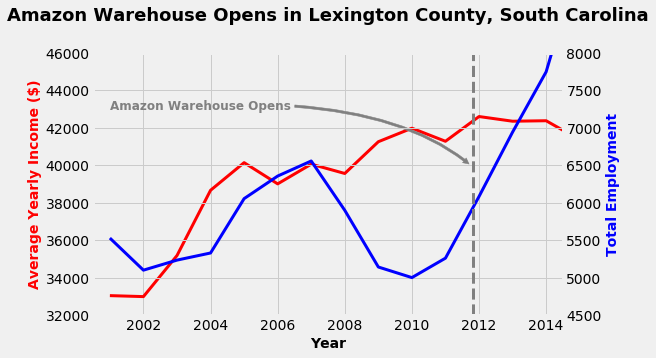

In [37]:
fig, ax1 = plt.subplots(figsize = (7.5, 4.5))

ax2 = ax1.twinx()

sc_lexington1["AverageIncome"].plot(ax = ax1, color = "r", linewidth = 3.0, label = "Average Income")
sc_lexington1["TotalEmployment"].plot(ax = ax2, color = "b", linewidth = 3.0, label = "Total Employment")

ax1.set_title("Amazon Warehouse Opens in Lexington County, South Carolina", fontsize = 18, fontweight = "bold")
ax1.title.set_position([.5, 1.1])

ax1.set_xlabel("Year", fontsize = 14, fontweight = "bold")
ax1.set_ylabel("Average Yearly Income ($)", color = "r", fontsize = 14, fontweight = "bold")
ax2.set_ylabel("Total Employment", color = "b", fontsize = 14, fontweight = "bold")

ax1.set_xlim(2000.5, 2014.5)
ax1.set_ylim(32000, 46000)
ax2.set_ylim(4500, 8000)

plt.axvline(x = 2011.83, color = "gray", linewidth = 3.0, linestyle = "--")

ax1.annotate("Amazon Warehouse Opens", 
             xy = (2011.75, 40000), 
             xytext = (2001, 43000), 
             fontsize = 12,
             fontweight = "bold", 
             color = "gray", 
             arrowprops = {
                 "arrowstyle": "simple",
                 "connectionstyle": "angle3, angleA = 3, angleB = 140",
                 "color": "gray"})

plt.show()

Now that we have another version of the Lexington County graph, we can start to compare some details and draw further conclusions. This new graph is using data from not just the *493 NAICS 493 Warehousing and storage* industry, but also from every other industry in the broad category of *Transportation and warehousing (NAICS:48-49)* as a consequence of the nature of the data sets available.

Thus, any change in employment will be a reflection of the entire related industry, and not just the specific industry of Warehousing and storage. Here we see from 2012 until 2014, there was roughly a 2800 increase in total employment in the *Transporation and warehousing* industry. From our previous graph, we see that there was just over a 3000 increase in total employment in just the *Warehousing and storage* industry alone. This is suggestive that there were very little employment coming into the *Warehousing and storage* industry from closely related industries, at least within Lexington County.

---
### Time Series: Employment Change

Unfortunately, the previous graph as it is only depicts the scenario for Lexington County, South Carolina only. This could be a misrepresentation of data, as Lexington County could be the only county to show such results. To gain a more holistic understanding of the causal impact of Amazon warehouses, we aim to find the average change in total employment and wages from 2 years before and after an Amazon warehouse is introduced in all counties.

This will allow us to have a better idea of what the average impact of Amazon warehouses given a random county. We will add touches later on to make this proposed figure even more informative.

Using the data from MWPVL and the US Census Bureau, I was able to run a preliminary difference-in-differences analysis of the effects of Amazon Fulfilment Centers on employment levels within treated counties, with all counties as a control group. Within this analysis there were 92 counties as part of the treated group that were exposed to Amazon Fulfilment Centers. To run this analysis, I normalized the data of the total warehousing employment with the year prior to the opening of an Amazon Fulfilment Center as the base year. I chose this year because the majority of the employment from a fulfilment center occurs very shortly after its opening, and thus would be included in the opening year. I then averaged these normalized figures from two years before to two years after the treatment. For the control group, I used the same base years as the treated counties.

This data set is very similar to the data set above, except now it has treatment variables for Amazon Fulfilment Centers, as well as a variable indicating whether the county is a Metropolitan Statistical Area, Micropolitan Statistical Area, or neither.

**First, read in the merged csv. file:**

In [32]:
master = pd.read_csv("C://Users//scott//Dropbox//Documents//Research//Honors Program//amazon_treated_counties.csv")
united_states = pd.read_csv("C://Users//scott//Dropbox//Documents//Research//Honors Program//united_states.csv")

**Here we have all treated counties, along with the variables of interest for years 2001 to 2017. We also have the same information for all of the United States for the same years:**

In [33]:
master.head(17)

,County,Year,BPE,TotalWarehousingEmployment,GeoFips,State,AverageWarehousingIncome,CountyFips,YearTreated,CountyTreated,...,CenterSize5,CenterSize6,CenterSize7,CenterSize8,CenterSize9,CenterSize10,CenterSize11,CenterSize12,Population2012,CountyType
0,"Alameda, CA",2001,0,NaN,6001,CA,NaN,1,2013,1,...,0,0.0,0,0,0,0,0,0,1554720.0,Metropolitan Statistical Area
1,"Alameda, CA",2002,0,NaN,6001,CA,NaN,1,2013,1,...,0,0.0,0,0,0,0,0,0,1554720.0,Metropolitan Statistical Area
2,"Alameda, CA",2003,0,NaN,6001,CA,NaN,1,2013,1,...,0,0.0,0,0,0,0,0,0,1554720.0,Metropolitan Statistical Area
3,"Alameda, CA",2004,0,NaN,6001,CA,NaN,1,2013,1,...,0,0.0,0,0,0,0,0,0,1554720.0,Metropolitan Statistical Area
4,"Alameda, CA",2005,0,NaN,6001,CA,NaN,1,2013,1,...,0,0.0,0,0,0,0,0,0,1554720.0,Metropolitan Statistical Area
5,"Alameda, CA",2006,0,NaN,6001,CA,NaN,1,2013,1,...,0,0.0,0,0,0,0,0,0,1554720.0,Metropolitan Statistical Area
6,"Alameda, CA",2007,0,NaN,6001,CA,NaN,1,2013,1,...,0,0.0,0,0,0,0,0,0,1554720.0,Metropolitan Statistical Area
7,"Alameda, CA",2008,0,NaN,6001,CA,NaN,1,2013,1,...,0,0.0,0,0,0,0,0,0,1554720.0,Metropolitan Statistical Area
8,"Alameda, CA",2009,0,NaN,6001,CA,NaN,1,2013,1,...,0,0.0,0,0,0,0,0,0,1554720.0,Metropolitan Statistical Area
9,"Alameda, CA",2010,0,NaN,6001,CA,NaN,1,2013,1,...,0,0.0,0,0,0,0,0,0,1554720.0,Metropolitan Statistical Area


In [34]:
united_states.head(17)

,TotalWarehousingEmployment,GeoFips,GeoName,Year,AverageWarehousingIncome,CountyFips
0,5480000,0,United States,2001,37950.91241,0
1,5355300,0,United States,2002,38522.39837,0
2,5308500,0,United States,2003,39532.63634,0
3,5415800,0,United States,2004,40996.52868,0
4,5602300,0,United States,2005,41342.66283,0
5,5743900,0,United States,2006,41958.07726,0
6,5927900,0,United States,2007,43171.61221,0
7,5819600,0,United States,2008,43927.58953,0
8,5533200,0,United States,2009,43574.42348,0
9,5466200,0,United States,2010,44905.05287,0


**Now merge the two DataFrames so we may begin our analysis:**

In [35]:
compare = pd.merge(master, united_states, how = "outer", on = "Year")

compare.sort_values(by = "Year", inplace = True)

compare.set_index(["County", "Year"], inplace = True)

compare.sort_index(level = "County", inplace = True)

compare.head(20)

BPE  TotalWarehousingEmployment_x  GeoFips_x State  \
County        Year                                                       
Alameda, CA   2001    0                           NaN       6001    CA   
              2002    0                           NaN       6001    CA   
              2003    0                           NaN       6001    CA   
              2004    0                           NaN       6001    CA   
              2005    0                           NaN       6001    CA   
              2006    0                           NaN       6001    CA   
              2007    0                           NaN       6001    CA   
              2008    0                           NaN       6001    CA   
              2009    0                           NaN       6001    CA   
              2010    0                           NaN       6001    CA   
              2011    0                           NaN       6001    CA   
              2012    0                       32627.0       6001    CA   
              2013    0                       33827.0       6001    CA   
              2014    0                       38462.0       6001    CA   
              2015    0                       47837.0       6001    CA   
              2016    0                       52034.0       6001    CA   
              2017    0                       54018.0       6001    CA   
Allegheny, PA 2001    1                       33801.0      42003    PA   
              2002    1                       31322.0      42003    PA   
              2003    1                       29244.0      42003    PA   

                    AverageWarehousingIncome_x  CountyFips_x  YearTreated  \
County        Year                                                          
Alameda, CA   2001                         NaN             1         2013   
              2002                         NaN             1         2013   
              2003                         NaN             1         2013   
              2004                         NaN             1         2013   
              2005                         NaN             1         2013   
              2006                         NaN             1         2013   
              2007                         NaN             1         2013   
              2008                         NaN             1         2013   
              2009                         NaN             1         2013   
              2010                         NaN             1         2013   
              2011                         NaN             1         2013   
              2012                 56205.25945             1         2013   
              2013                 54221.15470             1         2013   
              2014                 49367.71359             1         2013   
              2015                 44604.21849             1         2013   
              2016                 43070.93439             1         2013   
              2017                 43567.58858             1         2013   
Allegheny, PA 2001                 59598.35508             3         2015   
              2002                 61712.91744             3         2015   
              2003                 61267.13172             3         2015   

                    CountyTreated  AmazonTreated  AmazonIntensity  \
County        Year                                                  
Alameda, CA   2001              1              0                0   
              2002              1              0                0   
              2003              1              0                0   
              2004              1              0                0   
              2005              1              0                0   
              2006              1              0                0   
              2007              1              0                0   
              2008              1              0                0   
      

**Now use the "BPE" variable indicator to filter out counties that are missing data so we won't run into any errors during the analysis:**

In [36]:
compare = compare[compare["BPE"] == 1]

compare = compare.groupby("County")

compare.head(20)

BPE  TotalWarehousingEmployment_x  GeoFips_x State  \
County        Year                                                       
Allegheny, PA 2001    1                       33801.0      42003    PA   
              2002    1                       31322.0      42003    PA   
              2003    1                       29244.0      42003    PA   
              2004    1                       28048.0      42003    PA   
              2005    1                       23970.0      42003    PA   
              2006    1                       22920.0      42003    PA   
              2007    1                       22746.0      42003    PA   
              2008    1                       21834.0      42003    PA   
              2009    1                       21649.0      42003    PA   
              2010    1                       20659.0      42003    PA   
              2011    1                       21009.0      42003    PA   
              2012    1                       21564.0      42003    PA   
              2013    1                       21760.0      42003    PA   
              2014    1                       22363.0      42003    PA   
              2015    1                       25413.0      42003    PA   
              2016    1                       26910.0      42003    PA   
              2017    1                       27975.0      42003    PA   
Arapahoe, CO  2001    1                        5225.0       8005    CO   
              2002    1                        5540.0       8005    CO   
              2003    1                        5385.0       8005    CO   
              2004    1                        5185.0       8005    CO   
              2005    1                        5280.0       8005    CO   
              2006    1                        5545.0       8005    CO   
              2007    1                        6040.0       8005    CO   
              2008    1                        5899.0       8005    CO   
              2009    1                        5591.0       8005    CO   
              2010    1                        5375.0       8005    CO   
              2011    1                        5906.0       8005    CO   
              2012    1                        6423.0       8005    CO   
              2013    1                        6860.0       8005    CO   
...                 ...                           ...        ...   ...   
Worcester, MA 2005    1                       10290.0      25027    MA   
              2006    1                       10636.0      25027    MA   
              2007    1                       11095.0      25027    MA   
              2008    1                       10970.0      25027    MA   
              2009    1                       10270.0      25027    MA   
              2010    1                       11159.0      25027    MA   
              2011    1                       11836.0      25027    MA   
              2012    1                       11934.0      25027    MA   
              2013    1                       12291.0      25027    MA   
              2014    1                       12922.0      25027    MA   
              2015    1                       14663.0      25027    MA   
              2016    1                       15928.0      25027    MA   
              2017    1                       16316.0      25027    MA   
York, PA      2001    1                        6835.0      42133    PA   
              2002    1                        7400.0      42133    PA   
              2003    1                        7706.0      42133    PA   
              2004    1                        8446.0      42133    PA   
              2005    1                        8864.0      42133    PA   
              2006    1                        8947.0      42133    PA   
              2007    1                        9303.0      42133    PA   
              2008    1                        9107.0      42133    PA   
              2009    1 

Note how there are 1564 rows here, which means with 17 rows for each county there are 92 unique counties that have been treated with usable data.

**Now create a function to analyze the growth rate of employment within each county at the time of treatment:**

In [37]:
def employment_rate_county(df):
    
    data = [(100*(df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2004] - df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2003] - df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002] - df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2001] - df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2000] - df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment_x"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100]
    
    data = pd.DataFrame(data).T
    
    data.columns = ["-2", "-1", "0", "1", "2"]
    
    return data

def employment_rate_us(df):
    
    data = [(100*(df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2004] - df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2003] - df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002] - df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2001] - df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2000] - df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment_y"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100]
    
    data = pd.DataFrame(data).T
    
    data.columns = ["-2", "-1", "0", "1", "2"]
    
    return data

**Now apply these functions to each county and all counties in the DataFrames:**

In [38]:
rate_employment_us = compare.apply(employment_rate_us)

rate_employment_us = rate_employment_us.reset_index().drop(["level_1"], axis = 1).set_index("County")

rate_employment_us.head(10)

,-2,-1,0,1,2
County,,,,,
"Allegheny, PA",93.378327,95.708646,100.0,110.303387,117.999491
"Arapahoe, CO",86.768547,90.659047,100.0,106.977214,110.593532
"Bergen, NJ",93.378327,95.708646,100.0,110.303387,117.999491
"Berks, PA",94.312134,97.565194,100.0,104.483768,115.249135
"Bexar, TX",93.378327,95.708646,100.0,110.303387,117.999491
"Boone, IN",94.507330,96.896034,100.0,98.173046,93.341656
"Boone, KY",98.882898,98.018760,100.0,103.443628,106.058200
"Bradley, TN",106.465186,101.225714,100.0,103.743002,107.321357
"Burlington, NJ",86.768547,90.659047,100.0,106.977214,110.593532


In [39]:
rate_employment_county = compare.apply(employment_rate_county)

rate_employment_county = rate_employment_county.reset_index().drop(["level_1"], axis = 1).set_index("County")

rate_employment_county.head(10)

,-2,-1,0,1,2
County,,,,,
"Allegheny, PA",96.427134,97.303582,100.0,113.638599,120.332692
"Arapahoe, CO",69.935773,80.986849,100.0,121.673973,125.099399
"Bergen, NJ",94.919698,97.596416,100.0,117.879384,127.297061
"Berks, PA",117.449239,95.526650,100.0,111.944797,119.574873
"Bexar, TX",91.231726,95.707886,100.0,109.188457,122.769733
"Boone, IN",98.433735,97.228916,100.0,116.987952,114.397590
"Boone, KY",81.306617,88.163657,100.0,96.664467,78.720979
"Bradley, TN",66.946108,103.313373,100.0,101.676647,106.506986
"Burlington, NJ",108.240258,100.744602,100.0,131.943410,149.429139


**Now average these figures across all counties:**

In [40]:
mean_rate_employment_us = pd.DataFrame(rate_employment_us.mean())
mean_rate_employment_us.columns = ["Total Employment"]
mean_rate_employment_us.index.name = "Delta Years"
mean_rate_employment_us.reset_index(inplace = True)
mean_rate_employment_us["Delta Years"] = mean_rate_employment_us["Delta Years"].astype(float)

mean_rate_employment_us.set_index("Delta Years", inplace = True)

mean_rate_employment_us

,Total Employment
Delta Years,
-2.0,94.181172
-1.0,96.178597
0.0,100.000000
1.0,105.543602
2.0,111.139177


**Now plot it!**

In [11]:
mean_rate_employment_county = pd.DataFrame(rate_employment_county.mean())
mean_rate_employment_county.columns = ["Total Employment"]
mean_rate_employment_county.index.name = "Delta Years"
mean_rate_employment_county.reset_index(inplace = True)
mean_rate_employment_county["Delta Years"] = mean_rate_employment_county["Delta Years"].astype(float)

mean_rate_employment_county.set_index("Delta Years", inplace = True)

mean_rate_employment_county

,Total Employment
Delta Years,
-2.0,92.535880
-1.0,94.738791
0.0,100.000000
1.0,108.116751
2.0,118.867803


**Now plot it!**

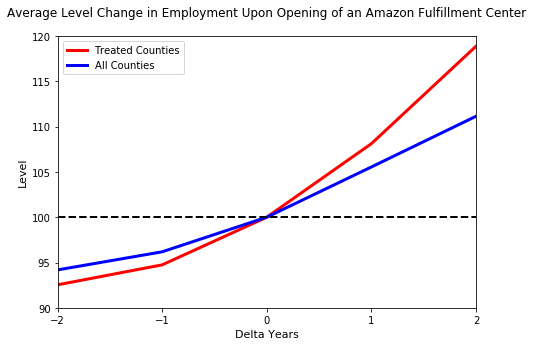

In [42]:
fig, ax1 = plt.subplots(figsize = (7.5, 5))

mean_rate_employment_county["Total Employment"].plot(ax = ax1, color = "r", linewidth = 3.0, label = "Treated Counties", xticks = [-2, -1, 0, 1, 2])
mean_rate_employment_us["Total Employment"].plot(ax = ax1, color = "b", linewidth = 3.0, label = "All Counties")

ax1.set_title("Average Level Change in Employment Upon Opening of an Amazon Fulfillment Center", fontsize = 12)
ax1.title.set_position([.5, 1.05])

ax1.set_xlabel("Delta Years", fontsize = 11)
ax1.set_ylabel("Level", fontsize = 11)

ax1.set_xlim(-2, 2)
ax1.set_ylim(90, 120)

plt.axhline(y = 100, color = "black", linewidth = 2.0, linestyle = "--")

ax1.legend()

plt.show()

Now this is very interesting! The figure shows a persuasive case that Amazon Fulfilment Centers do seem to have a causal impact on local employment. This is because while the employment levels of treated counties compared with all counties seem quite similar in the years preceding the opening of a fulfilment center, once the treatment happens treated counties exhibit strictly higher levels of employment. However, this effect may be an overestimate as counties that have been exposed to one fulfilment center are often treated by more than one in the following years. Therefore, I believe further analyses including the aforementioned regressions are necessary.

**Now retrive the interquartile range statistics: **

In [13]:
employment_quartile_county = rate_employment_county.describe().T.reset_index()

employment_quartile_county["Delta Years"] = employment_quartile_county["Delta Years"].astype(float)

employment_quartile_county = employment_quartile_county.drop(["count", "mean", "std", "min", "max"], axis = 1).set_index("Delta Years")

employment_quartile_county

,25%,50%,75%
Delta Years,,,
-2.0,86.553221,92.618135,96.937981
-1.0,91.788758,95.585672,98.262937
0.0,100.000000,100.000000,100.000000
1.0,102.997462,106.449857,112.254003
2.0,107.352597,116.303351,124.178700


In [14]:
employment_quartile_us = rate_employment_us.describe().T.reset_index()

employment_quartile_us["Delta Years"] = employment_quartile_us["Delta Years"].astype(float)

employment_quartile_us = employment_quartile_us.drop(["count", "mean", "std", "min", "max"], axis = 1).set_index("Delta Years")

employment_quartile_us

,25%,50%,75%
Delta Years,,,
-2.0,93.178099,93.378327,94.312134
-1.0,95.708646,96.392043,97.565194
0.0,100.000000,100.000000,100.000000
1.0,103.449249,104.483768,110.303387
2.0,107.091231,110.593532,117.999491


**Now plot them!**

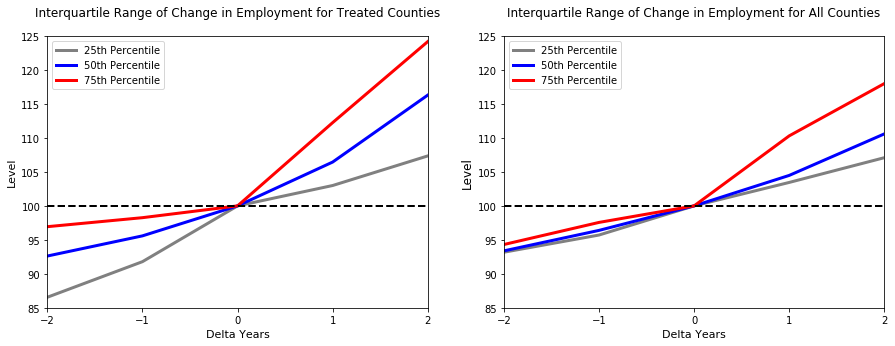

In [43]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

employment_quartile_county["25%"].plot(ax = ax[0], lw = 3, color = "gray", label = "25th Percentile", xticks = [-2, -1, 0, 1, 2])
employment_quartile_county["50%"].plot(ax = ax[0], lw = 3, color = "b", label = "50th Percentile")
employment_quartile_county["75%"].plot(ax = ax[0], lw = 3, color = "r", label = "75th Percentile")

employment_quartile_us["25%"].plot(ax = ax[1], lw = 3, color = "gray", label = "25th Percentile", xticks = [-2, -1, 0, 1, 2])
employment_quartile_us["50%"].plot(ax = ax[1], lw = 3, color = "b", label = "50th Percentile")
employment_quartile_us["75%"].plot(ax = ax[1], lw = 3, color = "r", label = "75th Percentile")

ax[0].title.set_position([.5, 1.05])
ax[1].title.set_position([.5, 1.05])
ax[1].title.set_position([.5, 1.05])

ax[0].set_xlim(-2, 2)
ax[1].set_xlim(-2, 2)

ax[0].set_ylim(85, 125)
ax[1].set_ylim(85, 125)

ax[0].set_xticks([-2, -1, 0, 1, 2])
ax[1].set_xticks([-2, -1, 0, 1, 2])

ax[0].set_xlabel("Delta Years", fontsize = 11)
ax[1].set_xlabel("Delta Years", fontsize = 11)

ax[0].set_ylabel("Level", fontsize = 11)
ax[1].set_ylabel("Level", fontsize = 12)

ax[0].set_title("Interquartile Range of Change in Employment for Treated Counties", fontsize = 12)
ax[1].set_title("Interquartile Range of Change in Employment for All Counties", fontsize = 12)

ax[0].axhline(y = 100, color = "black", linewidth = 2.0, linestyle = "--")
ax[1].axhline(y = 100, color = "black", linewidth = 2.0, linestyle = "--")

ax[0].legend()
ax[1].legend()

plt.show()

---
### Time Series: Average Income Change

We will now do the same analysis that we conducted for employment levels on average income levels. It will be interesting to see if a similar pattern is observed, and if not, why it might be the case.

**Define similar functions to identify the level change of average income of counties after treatment:**

In [44]:
def income_rate_county(df):
    
    data = [(100*(df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2004] - df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2003] - df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002] - df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2001] - df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2000] - df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome_x"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100]
    
    data = pd.DataFrame(data).T
    
    data.columns = ["-2", "-1", "0", "1", "2"]
    
    return data

def income_rate_us(df):
    
    data = [(100*(df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2004] - df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2003] - df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002] - df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2001] - df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2000] - df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome_y"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100]
    
    data = pd.DataFrame(data).T
    
    data.columns = ["-2", "-1", "0", "1", "2"]
    
    return data

**Now apply these functions to each treated county and all counties in the DataFrames:**

In [45]:
rate_income_us = compare.apply(income_rate_us)

rate_income_us = rate_income_us.reset_index().drop(["level_1"], axis = 1).set_index("County")

rate_income_us.head(10)

,-2,-1,0,1,2
County,,,,,
"Allegheny, PA",99.170606,99.799351,100.0,97.655831,94.786443
"Arapahoe, CO",102.194974,102.400439,100.0,97.061734,99.586309
"Bergen, NJ",99.170606,99.799351,100.0,97.655831,94.786443
"Berks, PA",97.241787,99.369991,100.0,100.201052,97.852171
"Bexar, TX",99.170606,99.799351,100.0,97.655831,94.786443
"Boone, IN",95.763537,97.189044,100.0,101.751098,100.933047
"Boone, KY",93.965025,96.429229,100.0,100.844301,102.345439
"Bradley, TN",97.823266,97.036794,100.0,102.063411,104.297140
"Burlington, NJ",102.194974,102.400439,100.0,97.061734,99.586309


In [46]:
rate_income_county = compare.apply(income_rate_county)

rate_income_county = rate_income_county.reset_index().drop(["level_1"], axis = 1).set_index("County")

rate_income_county.head(10)

,-2,-1,0,1,2
County,,,,,
"Allegheny, PA",100.608712,101.083144,100.0,95.111698,85.583279
"Arapahoe, CO",142.846780,124.283893,100.0,88.077082,92.395364
"Bergen, NJ",107.390603,102.429972,100.0,93.201735,87.222993
"Berks, PA",98.882849,99.209165,100.0,101.174056,106.055199
"Bexar, TX",99.407559,100.747607,100.0,102.156622,92.063840
"Boone, IN",96.831125,96.903924,100.0,106.990625,111.213252
"Boone, KY",97.599184,102.218675,100.0,93.468712,83.253998
"Bradley, TN",93.634325,96.457024,100.0,99.093832,102.509504
"Burlington, NJ",112.583048,107.392801,100.0,92.978603,93.919732


**Now average these figures across all counties:**

In [20]:
mean_rate_income_us = pd.DataFrame(rate_income_us.mean())
mean_rate_income_us.columns = ["Total Employment"]
mean_rate_income_us.index.name = "Delta Years"
mean_rate_income_us.reset_index(inplace = True)
mean_rate_income_us["Delta Years"] = mean_rate_income_us["Delta Years"].astype(float)

mean_rate_income_us.set_index("Delta Years", inplace = True)

mean_rate_income_us

,Total Employment
Delta Years,
-2.0,98.537673
-1.0,99.683627
0.0,100.000000
1.0,99.437001
2.0,99.107544


In [21]:
mean_rate_income_county = pd.DataFrame(rate_income_county.mean())
mean_rate_income_county.columns = ["Total Employment"]
mean_rate_income_county.index.name = "Delta Years"
mean_rate_income_county.reset_index(inplace = True)
mean_rate_income_county["Delta Years"] = mean_rate_income_county["Delta Years"].astype(float)

mean_rate_income_county.set_index("Delta Years", inplace = True)

mean_rate_income_county

,Total Employment
Delta Years,
-2.0,100.318770
-1.0,100.623486
0.0,100.000000
1.0,98.359887
2.0,97.072799


**Plot it!**

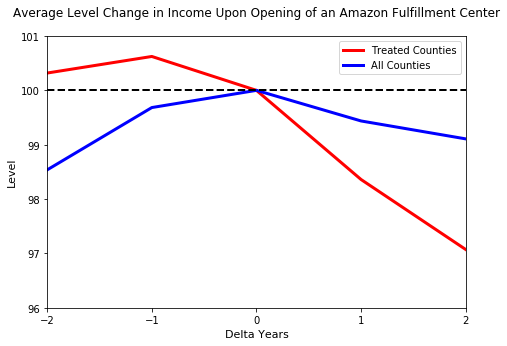

In [22]:
fig, ax1 = plt.subplots(figsize = (7.5, 5))

mean_rate_income_county["Total Employment"].plot(ax = ax1, color = "r", linewidth = 3.0, label = "Treated Counties", xticks = [-2, -1, 0, 1, 2])
mean_rate_income_us["Total Employment"].plot(ax = ax1, color = "b", linewidth = 3.0, label = "All Counties")

ax1.set_title("Average Level Change in Income Upon Opening of an Amazon Fulfillment Center", fontsize = 12)
ax1.title.set_position([.5, 1.05])

ax1.set_xlabel("Delta Years", fontsize = 11)
ax1.set_ylabel("Level", fontsize = 11)
# ax2.set_ylabel("% Change in Average Income", color = "b", fontsize = 14, fontweight = "bold")

ax1.set_xlim(-2, 2)
ax1.set_ylim(96, 101)
# ax2.set_ylim(90, )

plt.axhline(y = 100, color = "black", linewidth = 2.0, linestyle = "--")

# plt.style.use("ggplot")

ax1.legend()

plt.show()

Now this result is very different from what we saw from employment. Here we see that on average, treated counties exhibited higher levels of wage than all counties in the years before the opening of an Amazon Fulfilment Center. However, this changes drastically after the opening of the center, with average wage levels falling far below that of all counties. This is in contrast to employment levels, which we saw increased after treatment.

**Now retrive the interquartile range statistics: **

In [23]:
income_quartile_county = rate_income_county.describe().T.reset_index()

income_quartile_county["Delta Years"] = income_quartile_county["Delta Years"].astype(float)

income_quartile_county = income_quartile_county.drop(["count", "mean", "std", "min", "max"], axis = 1).set_index("Delta Years")

income_quartile_county

,25%,50%,75%
Delta Years,,,
-2.0,95.878854,99.023475,102.345151
-1.0,97.724545,99.339660,102.770559
0.0,100.000000,100.000000,100.000000
1.0,96.276955,99.048501,101.286663
2.0,92.375676,98.399669,101.935140


In [24]:
income_quartile_us = rate_income_us.describe().T.reset_index()

income_quartile_us["Delta Years"] = income_quartile_us["Delta Years"].astype(float)

income_quartile_us = income_quartile_us.drop(["count", "mean", "std", "min", "max"], axis = 1).set_index("Delta Years")

income_quartile_us

,25%,50%,75%
Delta Years,,,
-2.0,97.241787,99.075579,99.170606
-1.0,97.978305,99.799351,100.810489
0.0,100.000000,100.000000,100.000000
1.0,97.655831,100.201052,100.686578
2.0,94.786443,99.586309,100.860510


**Plot it!**

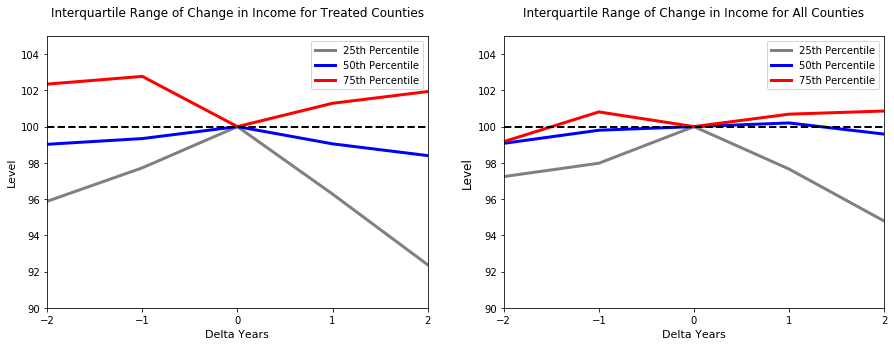

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

income_quartile_county["25%"].plot(ax = ax[0], lw = 3, color = "gray", label = "25th Percentile", xticks = [-2, -1, 0, 1, 2])
income_quartile_county["50%"].plot(ax = ax[0], lw = 3, color = "b", label = "50th Percentile")
income_quartile_county["75%"].plot(ax = ax[0], lw = 3, color = "r", label = "75th Percentile")

income_quartile_us["25%"].plot(ax = ax[1], lw = 3, color = "gray", label = "25th Percentile", xticks = [-2, -1, 0, 1, 2])
income_quartile_us["50%"].plot(ax = ax[1], lw = 3, color = "b", label = "50th Percentile")
income_quartile_us["75%"].plot(ax = ax[1], lw = 3, color = "r", label = "75th Percentile")

ax[0].title.set_position([.5, 1.05])
ax[1].title.set_position([.5, 1.05])

ax[0].set_xlim(-2, 2)
ax[1].set_xlim(-2, 2)

ax[0].set_ylim(90, 105)
ax[1].set_ylim(90, 105)

ax[0].set_xticks([-2, -1, 0, 1, 2])
ax[1].set_xticks([-2, -1, 0, 1, 2])

ax[0].set_xlabel("Delta Years", fontsize = 11)
ax[1].set_xlabel("Delta Years", fontsize = 11)

ax[0].set_ylabel("Level", fontsize = 11)
ax[1].set_ylabel("Level", fontsize = 12)

ax[0].set_title("Interquartile Range of Change in Income for Treated Counties", fontsize = 12)
ax[1].set_title("Interquartile Range of Change in Income for All Counties", fontsize = 12)

ax[0].axhline(y = 100, color = "black", linewidth = 2.0, linestyle = "--")
ax[1].axhline(y = 100, color = "black", linewidth = 2.0, linestyle = "--")

ax[0].legend()
ax[1].legend()

plt.show()

---
### Employment Level Change by Urban and Non-Urban Counties

Now we will use the data we extracted from the Census Bureau to see if the effects of the opening of an Amazon Fulfilment Center differs depending on whether a county is urban or not. 

As mentioned before, we will be using whether as county is a Metropolitan Statistical Area as the classification for being urban. If the county is a Micropolitan Statistical Area, or neither Metropolitan or Micropolitan, then it will count as a non-urban county.

**Create two separate DataFrames for Urban and Non-Urban Counties:**

In [51]:
master.sort_values(by = "Year", inplace = True)

master.set_index(["County", "Year"], inplace = True)

master.sort_index(level = "County", inplace = True)

master = master[master["BPE"] == 1]

df_msa = master[master["CountyType"] == "Metropolitan Statistical Area"]
df_msa = df_msa.groupby("County")

df_nomsa = master[master["CountyType"] != "Metropolitan Statistical Area"]
df_nomsa = df_nomsa.groupby("County")

In [56]:
df_msa.size()

County
Allegheny, PA                        17
Arapahoe, CO                         17
Bergen, NJ                           17
Berks, PA                            17
Bexar, TX                            17
Boone, IN                            17
Boone, KY                            17
Bradley, TN                          17
Burlington, NJ                       17
Chesapeake (Independent City), VA    17
Chesterfield, VA                     17
Clark, IN                            17
Clark, NV                            17
Cobb, GA                             17
Cook, IL                             17
Cumberland, PA                       17
Dakota, MN                           17
Dallas, TX                           17
Dauphin, PA                          17
Davidson, TN                         17
Denton, TX                           17
DuPage, IL                           17
Franklin, OH                         17
Fulton, GA                           17
Gloucester, NJ                   

In [55]:
df_nomsa.size()

County
Fairfax, Fairfax City + Falls Church, VA*    17
Orange, IN                                   17
Wayne, PA                                    17
dtype: int64

Here we come across something very interesting, and also concerning. We notice that out of the 92 treated counties, only 3 of them are not Metropolitan Statistical Areas. This tells us three main points:

* Amazon seems to intentionally set up their fulfilment centers in more populated counties, which does have intuitive reasoning behind it as they would be geographically closer to more of their consumers.
* With only 3 observations for non-urban counties, we will not be able to trust the results we find as being conclusive.
* We may instead have to use some other metric to define what it means for a county to be urban, such as population density.

However, we will go ahead and run our analysis for now using our current classification.

**Define similar functions as before for identifying employment and average income level changes:**

In [28]:
def employment_rate(df):
    
    data = [(100*(df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2004] - df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2003] - df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002] - df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2001] - df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2000] - df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["TotalWarehousingEmployment"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100]
    
    data = pd.DataFrame(data).T
    
    data.columns = ["-2", "-1", "0", "1", "2"]
    
    return data

def income_rate(df):
    
    data = [(100*(df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2004] - df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2003] - df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002] - df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2001] - df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100,
            (100*(df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2000] - df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002]) / df["AverageWarehousingIncome"].iloc[df["YearTreated"].iloc[0] - 2002]) + 100]
    
    data = pd.DataFrame(data).T
    
    data.columns = ["-2", "-1", "0", "1", "2"]
    
    return data

**Now apply these functions on both urban and non-urban counties:**

In [29]:
df_msa_rate = df_msa.apply(employment_rate)
df_msa_rate = df_msa_rate.reset_index().drop(["level_1"], axis = 1).set_index("County")

df_msa_mean = pd.DataFrame(df_msa_rate.mean())
df_msa_mean.columns = ["Total Employment"]
df_msa_mean.index.name = "Delta Years"
df_msa_mean.reset_index(inplace = True)
df_msa_mean["Delta Years"] = df_msa_mean["Delta Years"].astype(float)
df_msa_mean.set_index("Delta Years", inplace = True)

df_msa_mean

,Total Employment
Delta Years,
-2.0,92.514016
-1.0,94.749760
0.0,100.000000
1.0,108.244194
2.0,119.179511


In [30]:
df_nomsa_rate = df_nomsa.apply(employment_rate)
df_nomsa_rate = df_nomsa_rate.reset_index().drop(["level_1"], axis = 1).set_index("County")

df_nomsa_mean = pd.DataFrame(df_nomsa_rate.mean())
df_nomsa_mean.columns = ["Total Employment"]
df_nomsa_mean.index.name = "Delta Years"
df_nomsa_mean.reset_index(inplace = True)
df_nomsa_mean["Delta Years"] = df_nomsa_mean["Delta Years"].astype(float)
df_nomsa_mean.set_index("Delta Years", inplace = True)

df_nomsa_mean

,Total Employment
Delta Years,
-2.0,93.184535
-1.0,94.413381
0.0,100.000000
1.0,104.335927
2.0,109.620461


**Plot it!**

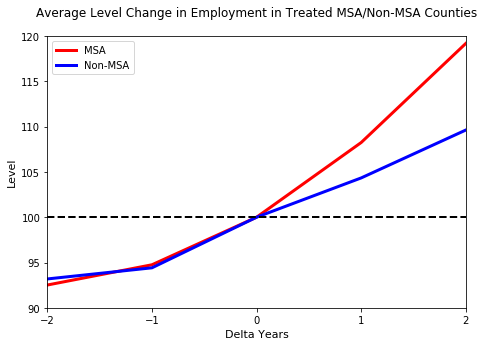

In [31]:
fig, ax1 = plt.subplots(figsize = (7.5, 5))

df_msa_mean["Total Employment"].plot(ax = ax1, color = "r", linewidth = 3.0, label = "MSA", xticks = [-2, -1, 0, 1, 2])
df_nomsa_mean["Total Employment"].plot(ax = ax1, color = "b", linewidth = 3.0, label = "Non-MSA")

ax1.set_title("Average Level Change in Employment in Treated MSA/Non-MSA Counties", fontsize = 12)
ax1.title.set_position([.5, 1.05])

ax1.set_xlabel("Delta Years", fontsize = 11)
ax1.set_ylabel("Level", fontsize = 11)

ax1.set_xlim(-2, 2)
ax1.set_ylim(90, 120)

plt.axhline(y = 100, color = "black", linewidth = 2.0, linestyle = "--")

ax1.legend()

plt.show()

Here we see a result that would have been interesting if we had not known that there were only 3 observations for non-urban counties. This is because the employment level trends for both urban and non-urban counties seem almost identical before an Amazon Fulfilment Center opening, but diverge as soon as the treatment occurs with only urban counties exhibiting the increased growth we previously saw.

---
### Conclusion and Future Steps

So we've come a long way since the original graph of Lexington County, South Carolina. We were able to show that, on average, counties that were treated with Amazon warehouses exhibited positive levels of growth in total employment.

We also showed that same was not true for average income. In fact we observed that counties treated with Amazon warehouses seemed to exhibit worse levels of income than the average county. This seems to be consistent with the initial findings of Lexington County, South Carolina.

Of course, this project is by no means a perfect analysis or proof that Amazon warehouses do indeed have a causal impact on economic variables such as employment and average income. To deal with issues such as omitted variable biases, more advanced econometric tools would be necessary. Here are the considerations going forward:

**Challenges with Empirical Analysis:**
* The most obvious challenge I face is selection bias regarding the location of Amazon Fulfilment Centers. Obviously, Amazon was not randomly choosing counties when deciding to open fulfilment centers; they had specific goals and criteria in mind. If this bias is unaccounted for, I may very well end up observing positive preexistent trends since Amazon could have only chosen counties with upward trajectories in employment and wages (or possibly the opposite). I have proposed fixed effects regressions and potential instrumental variables to address this issue.
* There are historic events unrelated to Amazon Fulfilment Centers that may have affected total employment and wages within the warehousing industry of counties. For example, the Great Recession in 2007 would have negatively impacted employment and wage levels. A fixed effects regression will help address this issue.
* Counties vary widely across the United States in a number of variables. Perhaps the most significant is size. Some counties are very small, especially near the east coast, while some are extremely large near the west coast. To account for this issue, I can scale down county data by the respective county population.
* Some counties have several Amazon Fulfilment Centers. This issue becomes more problematic when fulfilment centers open on dates very close to each other, as I may then be overestimating their effects. To address this, I can utilize a Cox Proportional-Hazards model.
* When using the data on square feet of total Amazon Fulfilment centers per county, I may be overestimating its effect since the values for square feet cannot be negative. For this issue, I can implement a Tobit model.
* Another significant obstacle is that an increase in employment in one county may simply be employment that has been displaced from other counties or industries. In this case, it is hard to definitively conclude whether Amazon has truly created employment or simply displaced labor from elsewhere.

**Challenges with Data Collection:**
* The current county-level data set from the BEA includes yearly data only. It would benefit the analyses if I can identify monthly data sources.
* I need to establish a new way to indicate which counties are urban, semi-urban, and rural. Instead of using Metropolitan Statistical Areas, I may need to use population density instead.
* The data concerning the proposed instrumental variables may not be available at all. In that case, I will need to do further research to obtain such data or find other possible instrumental variables of which the data is available.

Nevertheless, the project displays a more holistic overview of what the causal impact of Amazon warehouses would look like than figure in The Economist article, which was the original goal of this project!